---
cache: false
---

# Linear Regression

So far in these notes, we have almost exclusively considered the *classification problem*: given some data with categorical labels, we aim to learn patterns in the data that will allow us to predict new labels for new unseen data. In the *regression  problem*, we instead aim to learn patterns in the data that will allow us to predict a *quantitative* variable. If you want to predict the future price of a stock, the GPA of a Middlebury College student, or the number of wildfires in Vermont per year, you need to solve a regression problem.

In these lecture notes we'll focus on the *linear* regression problem and some of its extensions. Linear regression is an easy object of focus for us because it can be formulated in the framework of empirical risk minimization that we have recently been developing. In its most fundamental form, linear regression is the task of fitting a line to a cloud of points that display some kind of trend. Here's the simple picture:

<Axes: xlabel='Feature (x)', ylabel='Target (y)'>

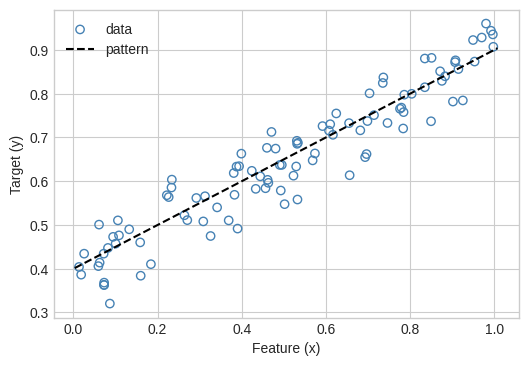

In [1]:
#| code-fold: true

import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def pad(x):
    return torch.cat([torch.ones(x.size(0), 1), x], dim = 1)

def regression_data(n = 100, w = torch.Tensor([0.4, 0.5]), phi = lambda x: x, x_max = 1):

    x = torch.rand(n, 1)*x_max
    x, ix = torch.sort(x)
    PHI = phi(x)
    PHI_ = pad(PHI)

    y = PHI_@w + 0.05*torch.randn(n)
    return x, y


def plot_regression_data(X, y, w = None, phi = lambda x: x, pattern_label = "pattern", ax = None, legend = True, xlabel = True, ylabel = True, title = None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    if xlabel:
        labels = ax.set(xlabel = "Feature (x)")
    if ylabel:
        labels = ax.set(ylabel = "Target (y)")
    if title:
        t = ax.set(title = title)


    ax.scatter(X, y, facecolors = "none", edgecolors = "steelblue", label = "data")
    if w is not None:
        m_points = 1001
        x_ = torch.linspace(X.min().item()-0.01, X.max().item()+0.01, m_points)
        x_ = x_.reshape(-1, 1)

        PHI = phi(x_)
        PHI_ = pad(PHI)

        y_ = PHI_@w

        ax.plot(x_, y_, linestyle = "dashed", color = "black", label = pattern_label)
        if legend:
            ax.legend()

    return ax


w = torch.Tensor([0.4, 0.5])


X, y = regression_data(w = w)
plot_regression_data(X, y, w = w)

Our aim is to approximately learn the pattern when we are allowed only to observe the points.

Theoretically, linear regression is *just another kind of empirical risk minimization*. In practice, it has a few extra tricks.

## Linear Regression as Empirical Risk Minimization

Consider the unregularized empirical risk minimization problem

$$
\begin{aligned}
\DeclareMathOperator*{\argmin}{argmin}
\newcommand{\bracket}[1]{\left\langle #1 \right\rangle}
\newcommand{\norm}[1]{\left\lVert #1 \right\rVert}
    \hat{\mathbf{w}} = \argmin_{\mathbf{w}} L(\mathbf{w}) = \argmin_{\mathbf{w}} \frac{1}{n} \sum_{i = 1}^n \ell (\bracket{\mathbf{w}, \phi(\mathbf{x}_i)}, y_i)\;.
\end{aligned}
$${#eq-unregularized-erm}

Here, $\ell$ is the *per-observation loss function* and $\phi$ is a *feature map*. When studying convexity, we introduced several different choices of $\ell$, including the 0-1 loss, logistic loss, and hinge loss.

Doing linear regression is as simple as choosing a different loss function. The most common choice is the square loss:

$$
\begin{aligned}
    \ell(s, y) = (s - y)^2\;.
\end{aligned}
$$

::: {.callout-note}

Check that this per-observation loss function is convex as a function of $s$.

:::

With this choice, empirical risk minimization becomes *least-squares linear regression*, with loss function

$$
\begin{aligned}
    L(\mathbf{w}) = \underbrace{\frac{1}{n} \sum_{i = 1}^n (\bracket{\mathbf{w}, \phi(\mathbf{x}_i)} - y_i)^2}_{\text{mean-squared error}}\;.
\end{aligned}
$${#eq-least-squares}

The first term in this expression is the mean-squared error (MSE). Motivation via the MSE is the most common way that least-squares linear regression is motivated in statistics courses.

One can use the second-derivative test to check that the square loss is convex in $s$, which means that all our standard theory from convex risk minimization translates to this setting as well. Gradient descent is one good method to learn the model and find $\hat{\mathbf{w}}$, although there are many other good ways as well.

## Matrix-Vector Formulation

It is possible to write @eq-least-squares much more simply using matrix-vector notation: [Here, $\lVert \mathbv{v} \rVert_2^2 = \sum_{i}v_i^2$ is the squared Euclidean norm.]{.aside}

$$
\begin{aligned}
    L(\mathbf{w}) = \frac{1}{n} \norm{\phi(\mathbf{X})\mathbf{w} - \mathbf{y}}_2^2\;.
\end{aligned}
$${#eq-least-squares-matrix}

By rules of multivariable differentiation, the gradient of the empirical risk $L(\mathbf{w})$ is [We looked at some gradients for the regularization term $R(\mathbf{w})$ in [previous notes](30-features-regularization.qmd).]{.aside}

$$
\nabla L(\mathbf{w}) = \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\mathbf{w} - \mathbf{y})\;.
$${#eq-gradient}

Using this gradient for a gradient-descent scheme would be a perfectly reasonable way to go about solving a least-squares linear regression problem.

## Closed-Form Expression for Linear Regression

However, there is something special about least-squares linear regression: it's actually not necessary to use gradient descent for small instances! Instead, we can solve the equation $\nabla L(\hat{\mathbf{w}}) = \mathbf{0}$ directly. Starting from @eq-gradient, we can calculate

$$
\begin{aligned}
    \mathbf{0} &= \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\hat{\mathbf{w}} - \mathbf{y})\;, \\
    \mathbf{0} &= \phi(\mathbf{X})^T\phi(\mathbf{X})\hat{\mathbf{w}} - \phi(\mathbf{X})^T\mathbf{y}\;, \\
    \phi(\mathbf{X})^T\phi(\mathbf{X})\hat{\mathbf{w}} &= \phi(\mathbf{X})^T\mathbf{y} \\
    \hat{\mathbf{w}} &= \left[\phi(\mathbf{X})^T\phi(\mathbf{X})\right]^{-1}\phi(\mathbf{X})^T\mathbf{y}\;,
\end{aligned}
$${#eq-linear-regression-closed}

provided that the matrix inverse exists. This is a closed-form expression for the least-squares regression problem: no gradient descent required! [This computation, though simple to describe, is not necessarily easy. The matrix $\mathbf{X}^T\mathbf{X}$ has dimensions $p\times p$, where $p$ is the number of features. When the number of features is very large, inverting this matrix may be computationally prohibitive.]{.aside}

Let's implement this formula for linear regression as a simple class:

In [2]:
#| code-fold: false

class LinearRegression:
    def __init__(self):
        self.w = None


    def predict(self, X):
      X_ = pad(X)
      return X_@self.w
    def mse(self, X, y):
      s = self.predict(X)
      return ((s-y)**2).mean()
    def fit(self, X, y):
        X_ = pad(X)
        self.w = torch.inverse(X_.T@X_)@X_.T@y

We can test this class on the data that we generated above, finding relatively good agreement with the data:

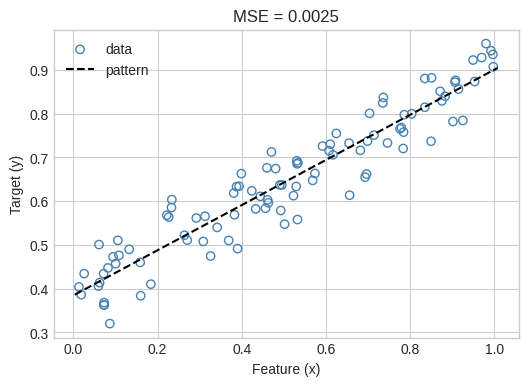

In [3]:
#| code-fold: false
lr = LinearRegression()
lr.fit(X, y)
ax = plot_regression_data(X, y, w = lr.w)
mse = lr.mse(X, y)

title = ax.set(title = f"MSE = {mse:.4f}")

## Linear Regression with Nonlinear Features

Suppose now that we wish to fit a regression model to some data that displays the following, nonlinear trend:

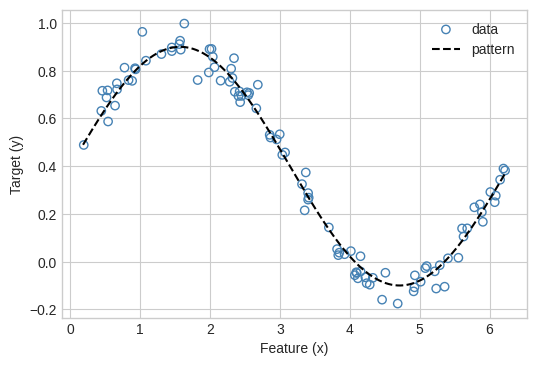

In [4]:
#| code-fold: false
X, y = regression_data(100, w, x_max=2*torch.pi, phi = torch.sin)
ax = plot_regression_data(X, y, w = w, phi = torch.sin)

One way to approach this is via polynomial feature maps, which we've seen before. Since we're using torch, we just need to define a helper function that outputs a tensor. We're dropping the constant column added by the `PolynomialFeatures` since we add that back in as part of our model internals.  

In [5]:
#| code-fold: false
from sklearn.preprocessing import PolynomialFeatures
def poly_features(degree = 2):
    pf = PolynomialFeatures(degree = degree)
    return lambda x: torch.Tensor(pf.fit_transform(x)[:,1:])


With the feature map `phi` implemented, we are now ready to fit a model using the same function as before:

In [6]:
#| code-fold: false
phi = poly_features(degree = 3)
PHI = phi(X)
lr = LinearRegression()
lr.fit(PHI, y)


How did we do?

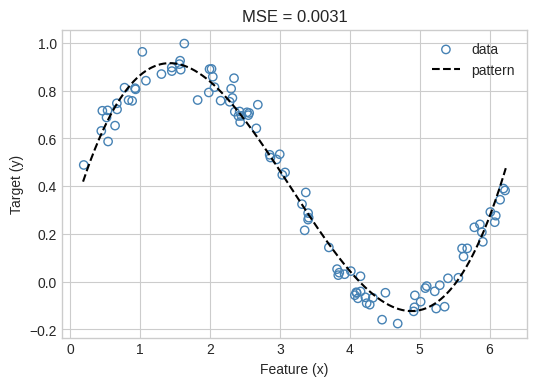

In [9]:
#| code-fold: false
ax = plot_regression_data(X, y, w = lr.w, phi = phi)
mse = lr.mse(PHI, y)
title = ax.set(title = f"MSE = {mse:.4f}")

## Predicting Health Costs

Let's use our linear regression model to predict the cost of healthcare per patient. The data set we'll use is from @obermeyerDissectingRacialBias2019b, which you may have encountered before. In this data set, each row corresponds to a patient. The data includes the gender, age, and race of the patient, as well as the results of various medical tests and other health-related characteristics.

In [10]:
#| code-fold: false
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df = df.dropna() # remove rows that have missing data

For the purpose of our analysis today, we'll discard the 1% of patients who had healthcare costs above $100,000. We'll also consider only a subset of the columns in the data set, including a few selected medical features, age, gender, and race. We'll also convert these into dummy columns.  

In [11]:
#| code-fold: false
df = df[df["cost_t"] <= 100000]

cols = [col for col in df.columns if "dem_age_band" in col and "18-24" not in col]
cols += [col for col in df.columns if "elixhauser" in col]
cols += [col for col in df.columns if "trig" in col]

cols += ["dem_female", "race"]

X_df = df[cols]
X_df = 1*pd.get_dummies(X_df, drop_first=True)
col_names = X_df.columns # for later

X_df.head()

,dem_age_band_25-34_tm1,dem_age_band_35-44_tm1,dem_age_band_45-54_tm1,dem_age_band_55-64_tm1,dem_age_band_65-74_tm1,dem_age_band_75+_tm1,alcohol_elixhauser_tm1,anemia_elixhauser_tm1,arrhythmia_elixhauser_tm1,arthritis_elixhauser_tm1,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,dem_female,race_white
1,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,1,1
8,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1,1,0
15,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
19,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
21,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,1,1


Now we can convert our feature data into a tensor. We'll also construct a tensor holding the cost of medical care received by the patient.

In [12]:
#| code-fold: false
X = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(df["cost_t"].values, dtype=torch.float32)

Finally, we'll split the data into training and validation sets for model evaluation.

In [13]:
#| code-fold: false
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=802)

Let's begin by calculating a baseline model performance. For this experiment, we'll consider the baseline prediction to be the mean cost per patient:

In [14]:
#| code-fold: false
mean_cost = y_train.mean()
mse_baseline = ((mean_cost - y_val)**2).mean()
mse_baseline


tensor(1.9167e+08)

The MSE of the baseline is quite high, indicating that different patients have very different amounts of healthcare spending. We'd like to achieve MSEs which are meaningfully lower than this on our validation set when modeling.

Let's begin our modeling efforts by fitting a simple linear regression model:

In [15]:
#| code-fold: false
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_performance = lr.mse(X_val, y_val)
print(lr_performance)

tensor(1.7944e+08)


This is already an improvement on the validation data! Can we do better? Maybe if we modeled some kind of nonlinear trend using polynomial features? To train and evaluate the model, we just need to construct the feature matrix by applying the feature map to the training and validation data.

In [16]:
#| eval: False
phi = poly_features(degree = 2)
PHI_train = phi(X_train)
lr = LinearRegression()
lr.fit(PHI_train, y_train)


_LinAlgError: linalg.inv: The diagonal element 45 is zero, the inversion could not be completed because the input matrix is singular.

```python
_LinAlgError                              Traceback (most recent call last)
File /Users/philchodrow/teaching/ml-notes/source/linear-regression.qmd:3
      1 PHI_train = phi(X_train)
      2 lr = LinearRegression()
----> 3 lr.fit(PHI_train, y_train)

Cell In[62], line 64
     62 def fit(self, X, y):
     63     X_ = pad(X)
---> 64     self.w = torch.inverse(X_.T@X_)@X_.T@y

_LinAlgError: linalg.inv: The diagonal element 45 is zero, the inversion could not be completed because the input matrix is singular.
```

The problem here is in the call `torch.inverse(X_.T@X_)` which is used in the `fit` method. According to the error, the matrix that we are trying to invert, $\Phi(\mathbf{X})^T\Phi(\mathbf{X})$, is singular; i.e. the columns are linearly dependent. The reason this happens is that the polynomial feature map $\Phi$ we've applied produces a *lot* of new columns. In fact, we face this issue in a lot of modern machine learning problems: we might have so many features that we don't even *know* whether the data is linearly dependent or not. Simply applying linear regression according to @eq-linear-regression-closed will not work for such data sets. We can address this issue using *regularization*.

## Ridge Regression

In ridge regression, we modify the empirical risk minimization problem @eq-least-squares by adding a *regularization term* to the loss function. The ridge-regularized empirical risk minimization problem is

$$
\begin{aligned}
    L(\mathbf{w}) &= \frac{1}{n}\left[ \lVert \Phi(\mathbf{X}) \mathbf{w} - \mathbf{y} \rVert_2^2 + \Lambda \lVert \mathbf{w}\rVert_2^2 \right] \\
           &= \underbrace{\frac{1}{n} \sum_{i = 1}^n (\bracket{\mathbf{w}, \phi(\mathbf{x}_i)} - y_i)^2} + \frac{\Lambda}{n} \sum_{j = 2}^p w_{j}^2  \;.
\end{aligned}
$${#eq-ridge-regression}

The second term in this expression is the *penalty term*. We can see that this term is large when the entries $w_{j}$ are large in magnitude. The effect of applying this term is therefore to shrink the entries of $\mathbf{w}$ towards zero. The parameter $\Lambda$ controls the strength of this effect: small values of $\Lambda$ lead to results very similar to standard linear regression, while large values of $\Lambda$ lead to very small values of $\mathbf{w}$.

There is a small important subtlety in the regularization term in @eq-ridge-regression: the sum over the entries of $\mathbf{w}$ starts at $j = 2$. We do this because the first entry of $\mathbf{w}$, $w_1$, corresponds to the constant feature and therefore corresponds to the overall scale of the data. Regularizing this term usually leads to systematic over- or under-estimation, and so we leave it out of the regularization term.

Fortunately, it's possible to derive a closed-form expression for the ridge regression problem in a way which is very similar to regular linear regression. We can write the regularized empirical risk in matrix form as


$$
\begin{aligned}
    L(\mathbf{w}) &= \frac{1}{n} \norm{\Phi(\mathbf{X})\mathbf{w} - \mathbf{y}}_2^2 + \frac{\Lambda}{n}\norm{\mathbf{U}\mathbf{w}}_2^2\;,
\end{aligned}
$$

where we've defined the matrix
$$
\begin{aligned}
    \mathbf{U} = \begin{pmatrix}
        0 & \mathbf{0}  \\
        \mathbf{0} & \mathbf{I}  
    \end{pmatrix}
\end{aligned}
$$

with a $0$ on the upper-left corner and the $(p-1)\times (p-1)$ identity matrix $\mathbf{I}$ in the lower-right corner. The effect of multiplication by $\mathbf{U}$ is to zero out the first entry of $\mathbf{w}$, therefore excluding it from the regularization term.

The gradient of the loss is

$$
\begin{aligned}
    \nabla L(\mathbf{w}) &= \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\mathbf{w} - \mathbf{y}) + 2\frac{\Lambda}{n} \mathbf{U}\mathbf{w}\;.
\end{aligned}
$$

Solving for $\mathbf{w}$ like before, we find our optimal parameter vector from the formula:

$$
\begin{aligned}
    \hat{\mathbf{w}} = \left[\phi(\mathbf{X})^T\phi(\mathbf{X}) + \Lambda \mathbf{U} \right]^{-1} \phi(\mathbf{X})^T\mathbf{y}\;.
\end{aligned}
$$

Let's construct a new class to implement ridge regression. We'll let this class inherit from `LinearRegression` so that we can use the same methods for prediction and scoring.

In [20]:
#| code-fold: false
class RidgeRegression(LinearRegression):
    def fit(self, X, y, lam = 0.01):
      X_ = pad(X)
      n, p = X_.size(0), X_.size(1)

      U = torch.zeros(p,p)
      U[1:, 1:] = torch.eye(p-1)

      self.w = torch.inverse(X_.T@X_ + lam*U)@X_.T@y

Let's go ahead and try out our ridge regression implementation:

In [21]:
#| code-fold: false
rr = RidgeRegression()
rr.fit(X_train, y_train, lam = 100)
rr_performance = rr.mse(X_val, y_val)
print(rr_performance)


tensor(1.7933e+08)


This is already a modest improvement over the linear regression performance of `{python} lr_performance`. Importantly, we can do even better with more features: it is possible to show that the matrix $\Phi(\mathbf{X})^T\Phi(\mathbf{X}) + \lambda \mathbf{U}$ is invertible whenever $\lambda > 0$. Let's try the same computation as last time:

In [24]:
#| code-fold: false
pf = PolynomialFeatures(degree = 3)
phi = lambda X: torch.Tensor(pf.fit_transform(X)[:,1:])

PHI_train = phi(X_train)
rr = RidgeRegression()
rr.fit(PHI_train, y_train, lam = 1000)

Unlike with simple linear regression, we were able to fit our model. Even better, we've realized another small reduction in the MSE:

In [23]:
PHI_val = phi(X_val)
rr_features_performance = rr.mse(PHI_val, y_val)
print(rr_features_performance)

tensor(1.7917e+08)


It's also possible to train with even higher-dimensional feature maps, although this tends to make our computations slow (inverting large matrices is expensive) and is not guaranteed to lead to performance improvements.

## Computational Complexity

Is that all there is to least-squares linear regression? Of course not!

### Other Regularizers

Not if we use different regularization terms! An especially popular regularizer is the $\ell_1$ regularizer, which penalizes entries of $\mathbf{w}$ based on their absolute value rather than their square. If we use this regularizer in addition to or instead of the $\ell_2$ regularization term, then we can't use the closed-form matrix formula above.

### Gradient Methods

More fundamentally, suppose that we have a *very* large number $p$ of features. The matrix $\Phi(\mathbf{X})^T\Phi(\mathbf{X}) + \lambda \mathbf{I}$ is a $p\times p$ matrix. The computational cost of *inverting* this matrix is $\Theta(n^\gamma)$ for some $\gamma$ between $2$ and $3$. For sufficiently large $p$, this may simply be infeasible. There are several approaches.

To perform **gradient descent** with least-squares linear regression, all we need is a formula for the gradient. @eq-gradient gives this formula -- we just plug in the gradient of the regularizing term and iterate to convergence.

Sometimes *even this* is too hard: for sufficiently large $p$, even computing the matrix multiplication $\Phi(\mathbf{X})^T\Phi(\mathbf{X})$ required for gradient descent is too computationally intensive. In this case, *stochastic* gradient methods can be used; we'll study these in a coming lecture.

## References
